### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import PIL
import networkx as nx
import itertools
from fa2 import ForceAtlas2
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches

from networkx.algorithms import community
import community
import random

import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud


%matplotlib inline

# 1) Basic Statistics

In this section, simple, basic statistics about the data (found from https://www.kaggle.com/ai-first/cocktail-ingredients) are explored, such as its shape and the number of unique categories and ingredients.

In [2]:
# Import data
df = pd.read_csv('all_drinks.csv', encoding = 'utf-8')

# Removes row "Unnamed"
cols = df.columns
cols = cols[1:]
data = np.array(df)[:,1:]
df = pd.DataFrame(np.array(df)[:,1:])
df.columns = cols

df.head()

# Remove comment to print the whole dataset
# df

,strDrink,dateModified,idDrink,strAlcoholic,strCategory,strDrinkThumb,strGlass,strIBA,strIngredient1,strIngredient10,...,strMeasure15,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strVideo
0,'57 Chevy with a White License Plate,2016-07-18 22:49:04,14029,Alcoholic,Cocktail,http://www.thecocktaildb.com/images/media/drin...,Highball glass,NaN,Creme de Cacao,NaN,...,NaN,1 oz,,,,,,NaN,NaN,NaN
1,1-900-FUK-MEUP,2016-07-18 22:27:04,15395,Alcoholic,Shot,http://www.thecocktaildb.com/images/media/drin...,Old-fashioned glass,NaN,Absolut Kurant,NaN,...,NaN,1/4 oz,1/4 oz,1/4 oz,1/4 oz,1/4 oz,1/2 oz,1/4 oz,,NaN
2,110 in the shade,2016-02-03 14:51:57,15423,Alcoholic,Beer,http://www.thecocktaildb.com/images/media/drin...,Beer Glass,NaN,Lager,NaN,...,NaN,1.5 oz,,,,,,NaN,NaN,NaN
3,151 Florida Bushwacker,2016-07-18 22:28:43,14588,Alcoholic,Milk / Float / Shake,http://www.thecocktaildb.com/images/media/drin...,Beer mug,NaN,Malibu rum,NaN,...,NaN,1/2 oz,1/2 oz Bacardi,1 oz,1 oz,3 oz,1 oz,1 cup,,NaN
4,155 Belmont,2016-10-05 12:36:28,15346,Alcoholic,Cocktail,http://www.thecocktaildb.com/images/media/drin...,White wine glass,NaN,Dark rum,NaN,...,NaN,2 shots,1 shot,1 shot,,,,,,NaN


In [3]:
print(df.shape)
cols

(546, 40)


Index(['strDrink', 'dateModified', 'idDrink', 'strAlcoholic', 'strCategory',
       'strDrinkThumb', 'strGlass', 'strIBA', 'strIngredient1',
       'strIngredient10', 'strIngredient11', 'strIngredient12',
       'strIngredient13', 'strIngredient14', 'strIngredient15',
       'strIngredient2', 'strIngredient3', 'strIngredient4', 'strIngredient5',
       'strIngredient6', 'strIngredient7', 'strIngredient8', 'strIngredient9',
       'strInstructions', 'strMeasure1', 'strMeasure10', 'strMeasure11',
       'strMeasure12', 'strMeasure13', 'strMeasure14', 'strMeasure15',
       'strMeasure2', 'strMeasure3', 'strMeasure4', 'strMeasure5',
       'strMeasure6', 'strMeasure7', 'strMeasure8', 'strMeasure9', 'strVideo'],
      dtype='object')

In [4]:
# Get Categories

categories = np.array(df['strCategory'])
unique_categories, counts = np.unique(categories, return_counts=True)
c = np.asarray((unique_categories, counts)).T
print(c)

[['Beer' 13]
 ['Cocktail' 64]
 ['Cocoa' 9]
 ['Coffee / Tea' 25]
 ['Homemade Liqueur' 12]
 ['Milk / Float / Shake' 17]
 ['Ordinary Drink' 275]
 ['Other/Unknown' 34]
 ['Punch / Party Drink' 37]
 ['Shot' 49]
 ['Soft Drink / Soda' 11]]


In [5]:
# Get Ingredients

ingredient_indices = cols[8:23]
ingredients = data[:,8:23]
# Concatenate
ingredients_all = np.concatenate(ingredients)
# Remove empty fields
ingredients_all = [i for i in ingredients_all if isinstance(i, str)]
unique_ingredients, counts = np.unique(ingredients_all, return_counts=True)
print(unique_ingredients[:20])

['151 proof rum' '7-Up' 'Absinthe' 'Absolut Citron' 'Absolut Kurant'
 'Absolut Peppar' 'Absolut Vodka' 'Advocaat' 'Agave Syrup' 'Agave syrup'
 'Ale' 'Allspice' 'Almond' 'Almond flavoring' 'Amaretto' 'Angelica root'
 'Angostura Bitters' 'Angostura bitters' 'Anis' 'Anise']


To conclude the novel statistical analysis on the data, it seems that the following features would be most useful for further analysis:

- Name of the drink
- Category
- Glass Type
- Ingredients

Furthermore, it is noteworthy, that the 'language' used in ingredients and instructions isn't particularly consistent (e.g. Agave Syrup | Agave syrup) which will be addressed in following analysis.

# 2) The Network

In this section, a network of drinks is constructed using shared ingredients to determine the weight of the edges.

In [6]:
dim = df.shape[0]

# Init graph
G = nx.Graph()
G.add_nodes_from(list(range(dim)))

In [7]:
# Dictionary containing edges and their corresponding weights
edges = {}

# Loop over ingredients
for ingredient in unique_ingredients:
    # Get indices of rows that have the ingredient
    indices = np.unique(np.where(data[:,8:23] == ingredient)[0])
    # Construct the pairwise combinations of indices
    pairs = list(itertools.combinations(indices, 2))
    for p in pairs:
        if p in edges:
            edges[p] += 1
        else:
            edges[p] = 1
        
for (n1, n2), w in edges.items():
    G.add_edge(n1, n2, weight=w)
    

# Construct a degree vector
d = dict(nx.degree(G))

In [8]:
sorted_edges = sorted(edges.items(), key=lambda kv: kv[1])
sorted_edges.reverse()
sorted_edges[:10]

[((8, 354), 6),
 ((274, 384), 6),
 ((246, 247), 6),
 ((269, 505), 5),
 ((264, 505), 5),
 ((264, 269), 5),
 ((247, 505), 5),
 ((247, 269), 5),
 ((247, 264), 5),
 ((246, 505), 5)]

Force Atlas 2 to determine the positions of network nodes.

In [9]:
# Set seed for reproductibility
random.seed(2)
# Init force atlas 2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=4.0,

                        # Performance
                        jitterTolerance=0.01,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.01,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:35<00:00, 55.69it/s]

BarnesHut Approximation  took  1.66  seconds
Repulsion forces  took  31.15  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  2.36  seconds
AdjustSpeedAndApplyForces step  took  0.22  seconds


Visualizations of the network using different measures to scale node size.

In [10]:
# Init color array
cols = np.empty(shape=dim, dtype='<U30')
# List of possible colors
#col_list = cm.rainbow(np.linspace(0,1,len(unique_categories) + 1))
col_list = np.array(['goldenrod', 'orangered', 'chocolate', 'tan', 'purple', 'maroon', 'green', 'dimgrey', 'steelblue', 'y', 'navy'])
#np.random.shuffle(col_list)

for i, c in enumerate(categories):
    j = np.where(unique_categories == c)[0][0]
    cols[i] = col_list[j]


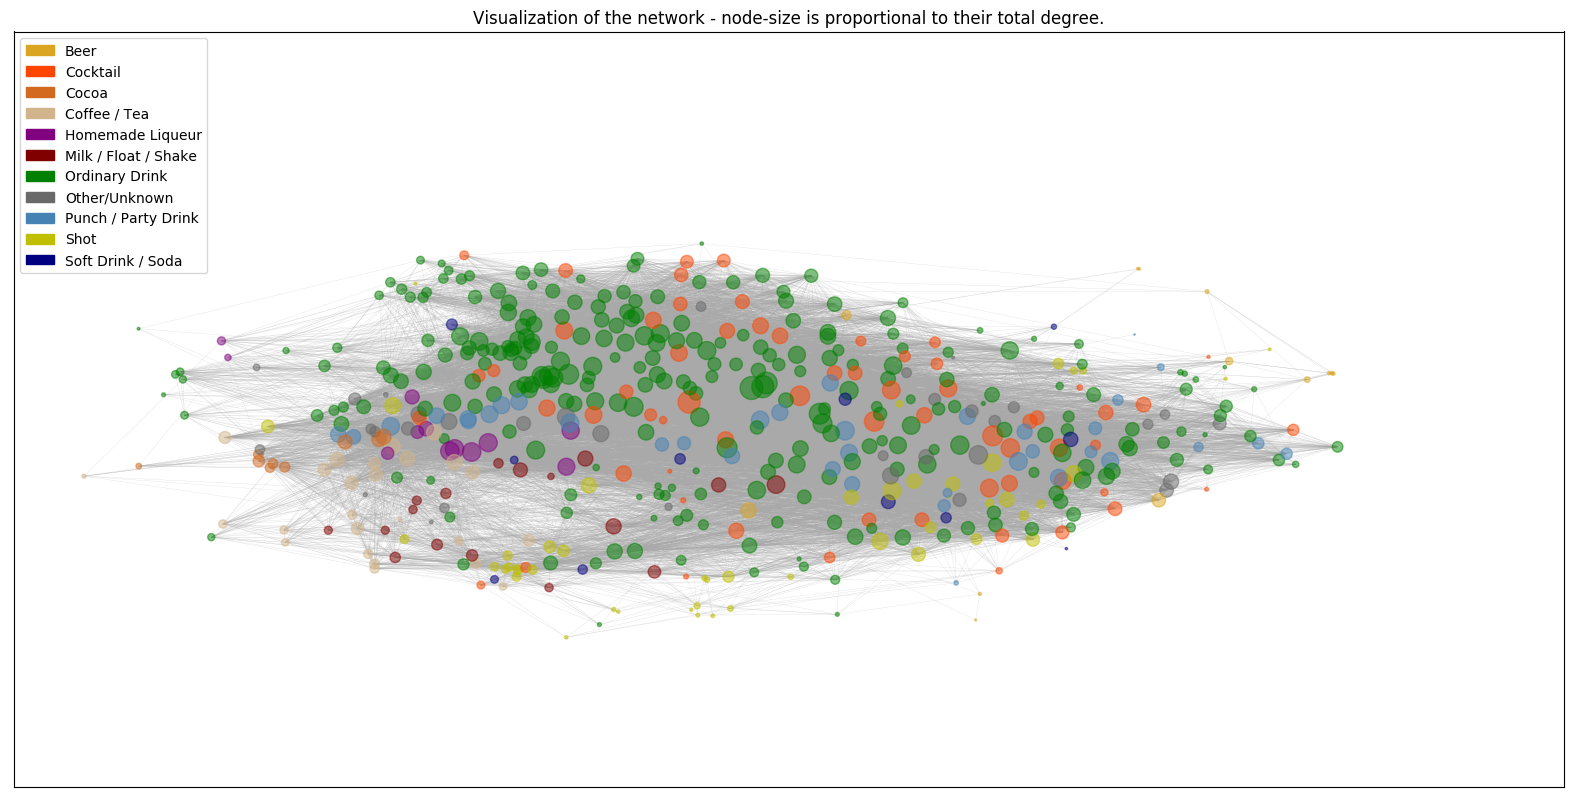

In [11]:
patches = []
for i, c in enumerate(unique_categories):
    patches.append(mpatches.Patch(color=col_list[i], label=c))

plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[v for v in d.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their total degree.')
    
plt.show()

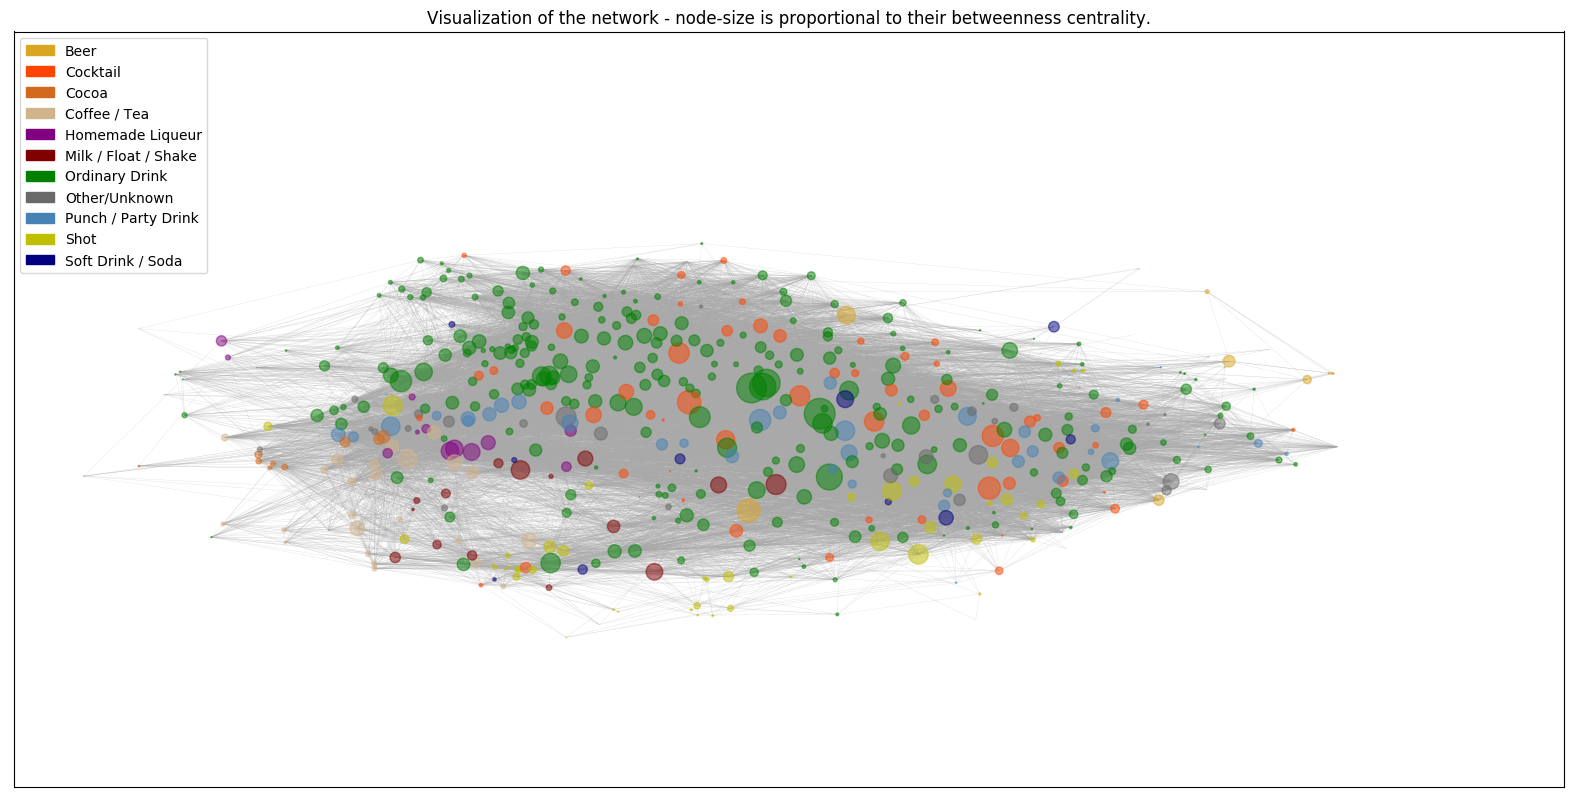

In [12]:
b = nx.betweenness_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[30000 * v for v in b.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their betweenness centrality.')
    
plt.show()

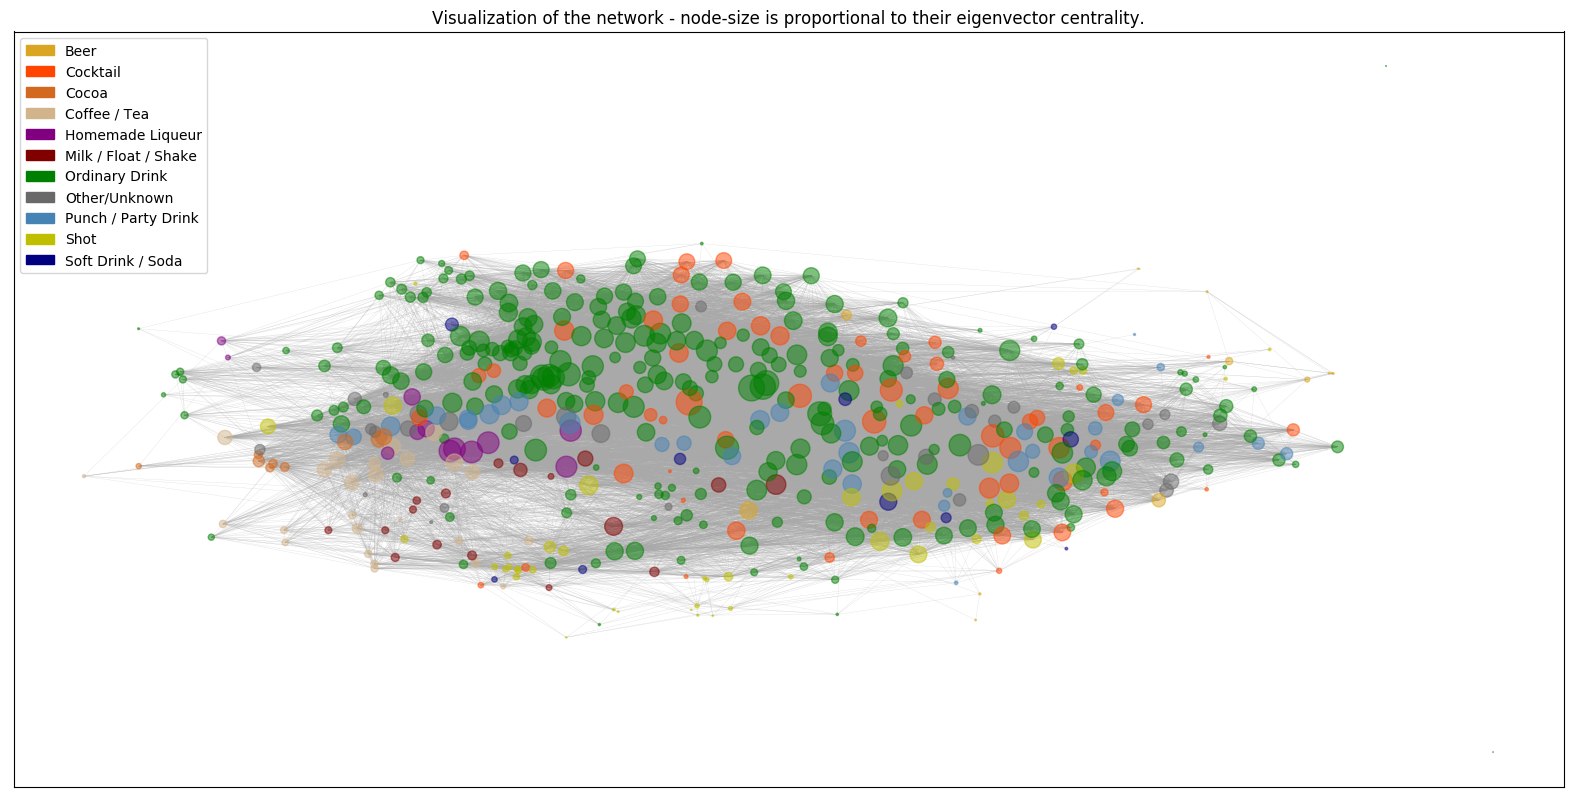

In [13]:
e = nx.eigenvector_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[3000 * v for v in e.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their eigenvector centrality.')
    
plt.show()

# 3) Community Detection

In this section, community detection is performed on the network using Louvain algorithm. Further analysis is also conducted on the main characteristics for the obtained communities, and the results are reflected with existing drink categories and glass types. 

In [14]:
# Use the Louvain algorithm for community detection
# set random state for reproductibility
partition = community.best_partition(G, random_state=4)
# Calculate modularity
mod = community.modularity(partition, G)

print('Modularity: {}'.format(mod))

Modularity: 0.364737222612753


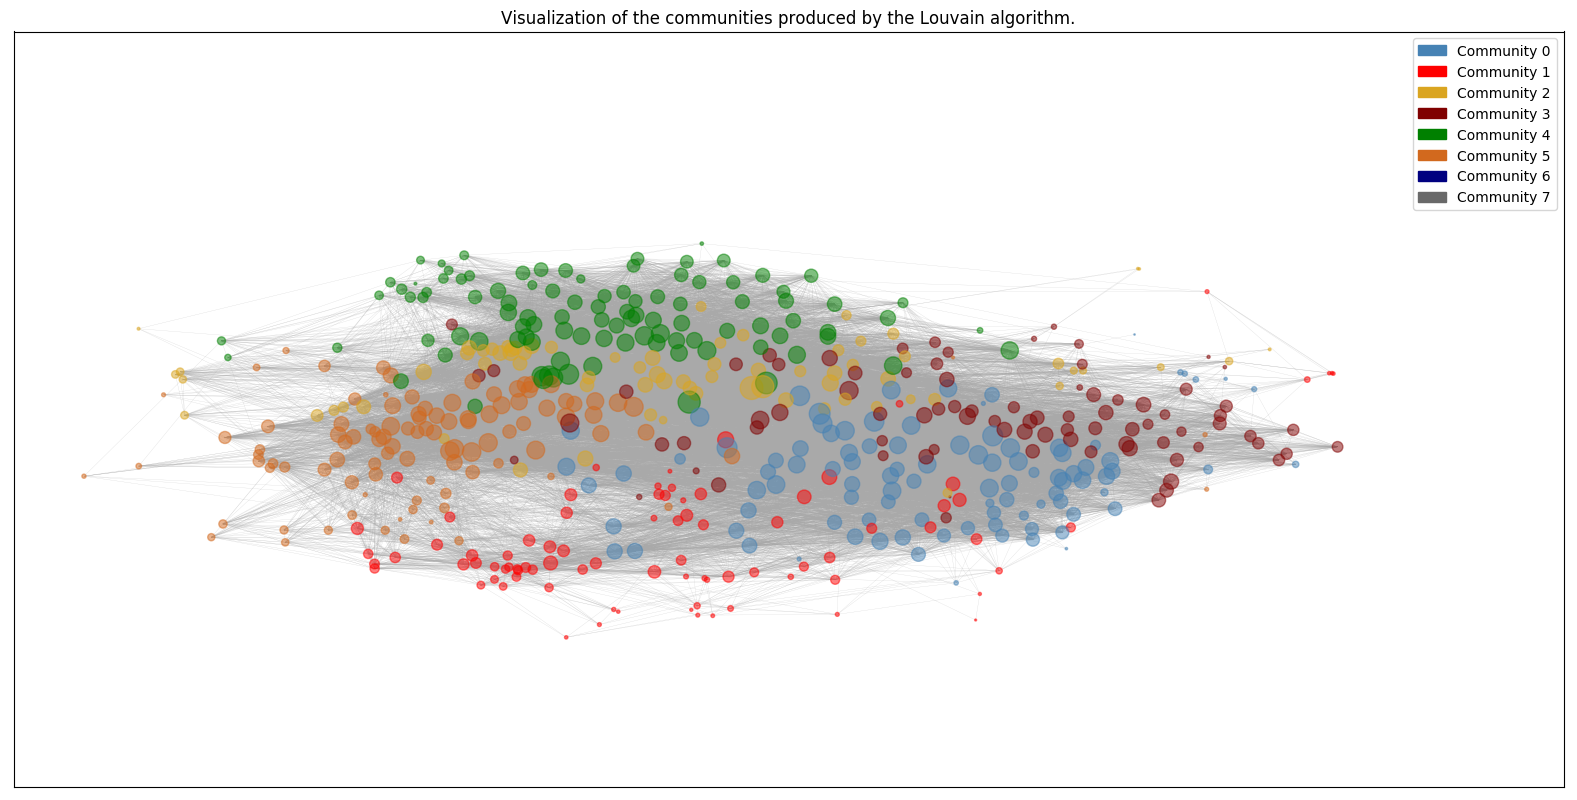

In [15]:
from matplotlib.pyplot import cm


n_of_communities = max(partition.values())

# Init color array
#cols = np.full(shape=(dim, 4), fill_value=1.000000)
cols = np.empty(shape=len(partition), dtype='<U30')

# List of possible colors
#col_list = cm.rainbow(np.linspace(0,1,n_of_communities + 1))
col_list = np.array(['steelblue', 'red', 'goldenrod', 'maroon', 'green', 'chocolate', 'navy', 'dimgrey'])
#np.random.shuffle(col_list)

patches = []
for i, c in enumerate(range(n_of_communities+1)):
    patches.append(mpatches.Patch(color=col_list[i], label='Community {}'.format(c)))

# Save colors according to the partition
for i, p in partition.items():
    cols[i] = col_list[p]

plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[v for v in d.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the communities produced by the Louvain algorithm.')
plt.show()

Confusion matrices for communities - categories and communities - glass-types.

In [16]:
glass_types = df['strGlass']
glass_types = np.array([s.lower() for s in glass_types])  # Non-case sensitive
unique_glass_types = np.unique(glass_types)
unique_glass_types

com_cat = np.zeros(shape=(n_of_communities + 1, len(unique_categories)), dtype='int')
com_glass = np.zeros(shape=(n_of_communities + 1, len(unique_glass_types)), dtype='int')

for i, p in partition.items():
    category = np.where(unique_categories == categories[i])
    glass_type = np.where(unique_glass_types == glass_types[i])
    com_cat[p][category] += 1
    com_glass[p][glass_type] += 1
    
com_cat = pd.DataFrame(com_cat)
com_cat.columns = unique_categories
com_cat = com_cat.T

com_glass = pd.DataFrame(com_glass)
com_glass.columns = unique_glass_types
com_glass = com_glass.T

In [17]:
com_cat

,0,1,2,3,4,5,6,7
Beer,1,7,4,1,0,0,0,0
Cocktail,19,8,5,14,14,4,0,0
Cocoa,0,0,0,0,0,9,0,0
Coffee / Tea,0,7,0,0,0,18,0,0
Homemade Liqueur,2,0,0,0,2,8,0,0
Milk / Float / Shake,2,5,2,1,0,7,0,0
Ordinary Drink,46,28,53,37,84,26,1,0
Other/Unknown,2,1,2,11,0,17,0,1
Punch / Party Drink,9,1,3,14,0,10,0,0
Shot,14,26,4,1,1,3,0,0


In [18]:
com_glass

,0,1,2,3,4,5,6,7
beer glass,0,0,2,0,0,0,0,0
beer mug,1,2,1,2,0,0,0,0
beer pilsner,1,1,3,0,0,0,0,0
brandy snifter,0,0,1,0,0,2,0,0
champagne flute,6,0,0,1,0,6,0,0
cocktail glass,13,15,24,18,51,4,0,0
coffee mug,0,5,0,0,0,18,0,0
collins glass,21,15,9,21,10,17,0,0
copper mug,1,0,0,0,0,0,0,0
cordial glass,0,0,0,0,1,0,0,0


Row- and columnwise heatmaps to visualize the confusion matrices.

In [19]:
import seaborn as sns; sns.set()

# Relative to rows

cat_row = com_cat.copy()
glass_row = com_glass.copy()

# Relative to cols

cat_col = com_cat.copy()
glass_col = com_glass.copy()

In [20]:
for i in range(cat_row.shape[0]):
    row = np.array(cat_row.iloc[i,:])
    s = np.sum(row)
    cat_row.iloc[i,:] = row / s
    
for i in range(cat_col.shape[1]):
    col = np.array(cat_col.iloc[:,i])
    s = np.sum(col)
    cat_col.iloc[:,i] = col / s

In [21]:
for i in range(glass_row.shape[0]):
    row = np.array(glass_row.iloc[i,:])
    s = np.sum(row)
    glass_row.iloc[i,:] = row / s
    
for i in range(glass_col.shape[1]):
    col = np.array(glass_col.iloc[:,i])
    s = np.sum(col)
    glass_col.iloc[:,i] = col / s

#### Heatmap of the communities w.r.t. to the corresponding categories. Results on the left are scaled by the row-sums of the confusion matrix and the results on the right are scaled by column-sums.

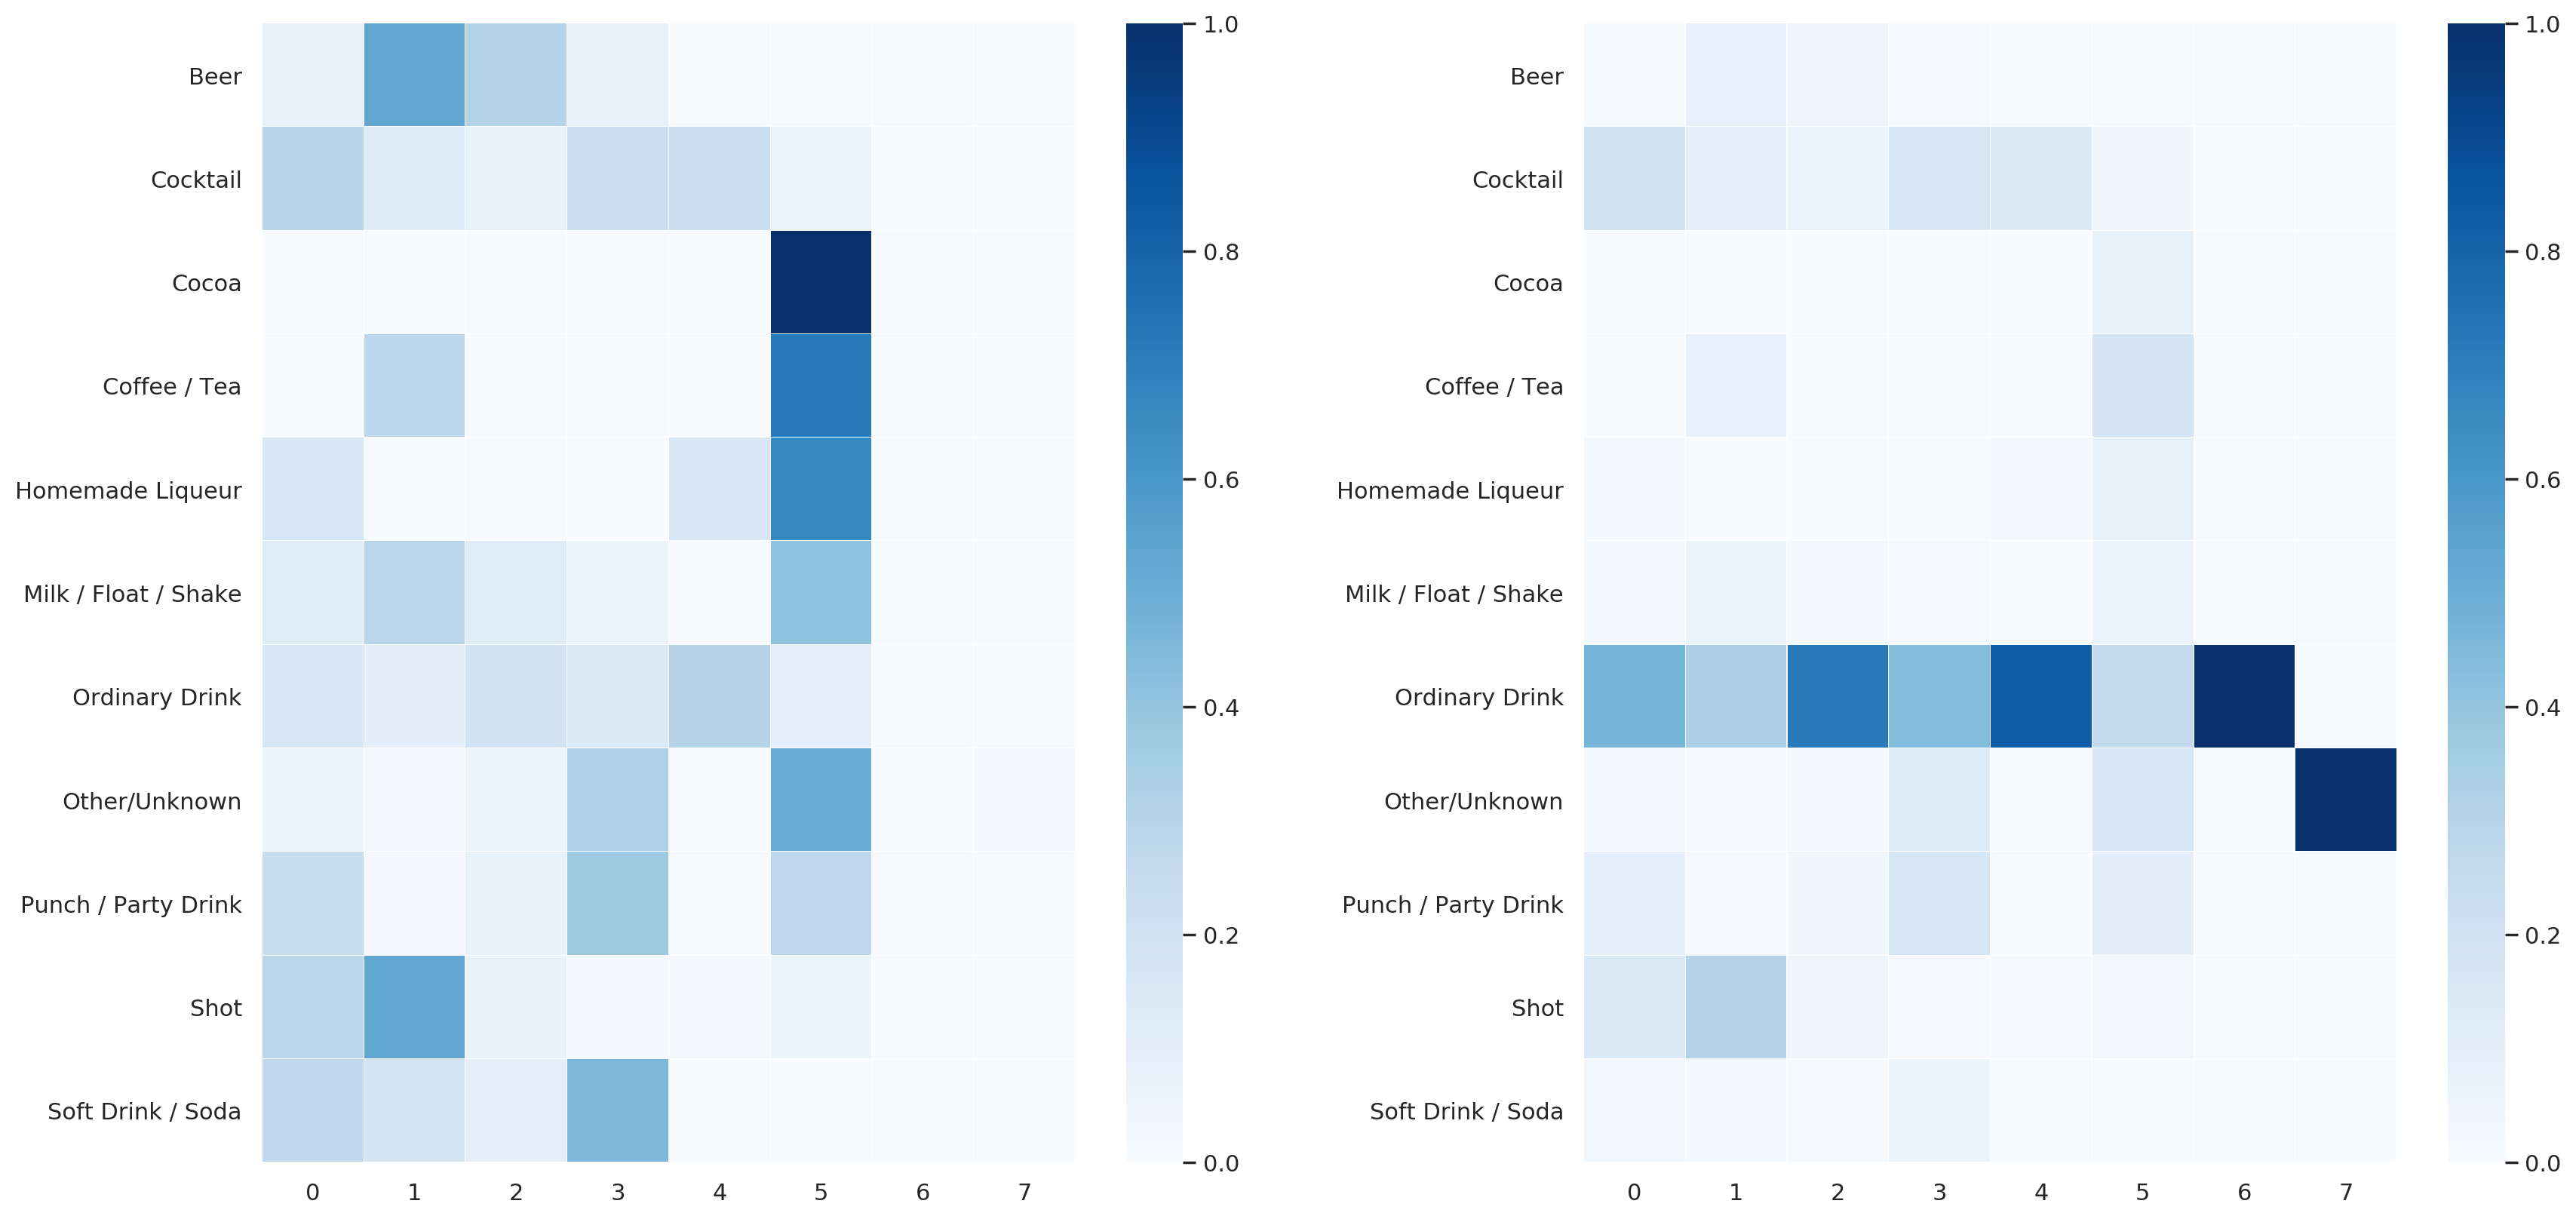

In [22]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cat_row, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(cat_col, linewidths = .01, cmap="Blues", ax=axs[1])

#### Heatmap of the communities w.r.t. to the corresponding glass-types. Results on the left are scaled by the row-sums of the confusion matrix and the results on the right are scaled by column-sums.

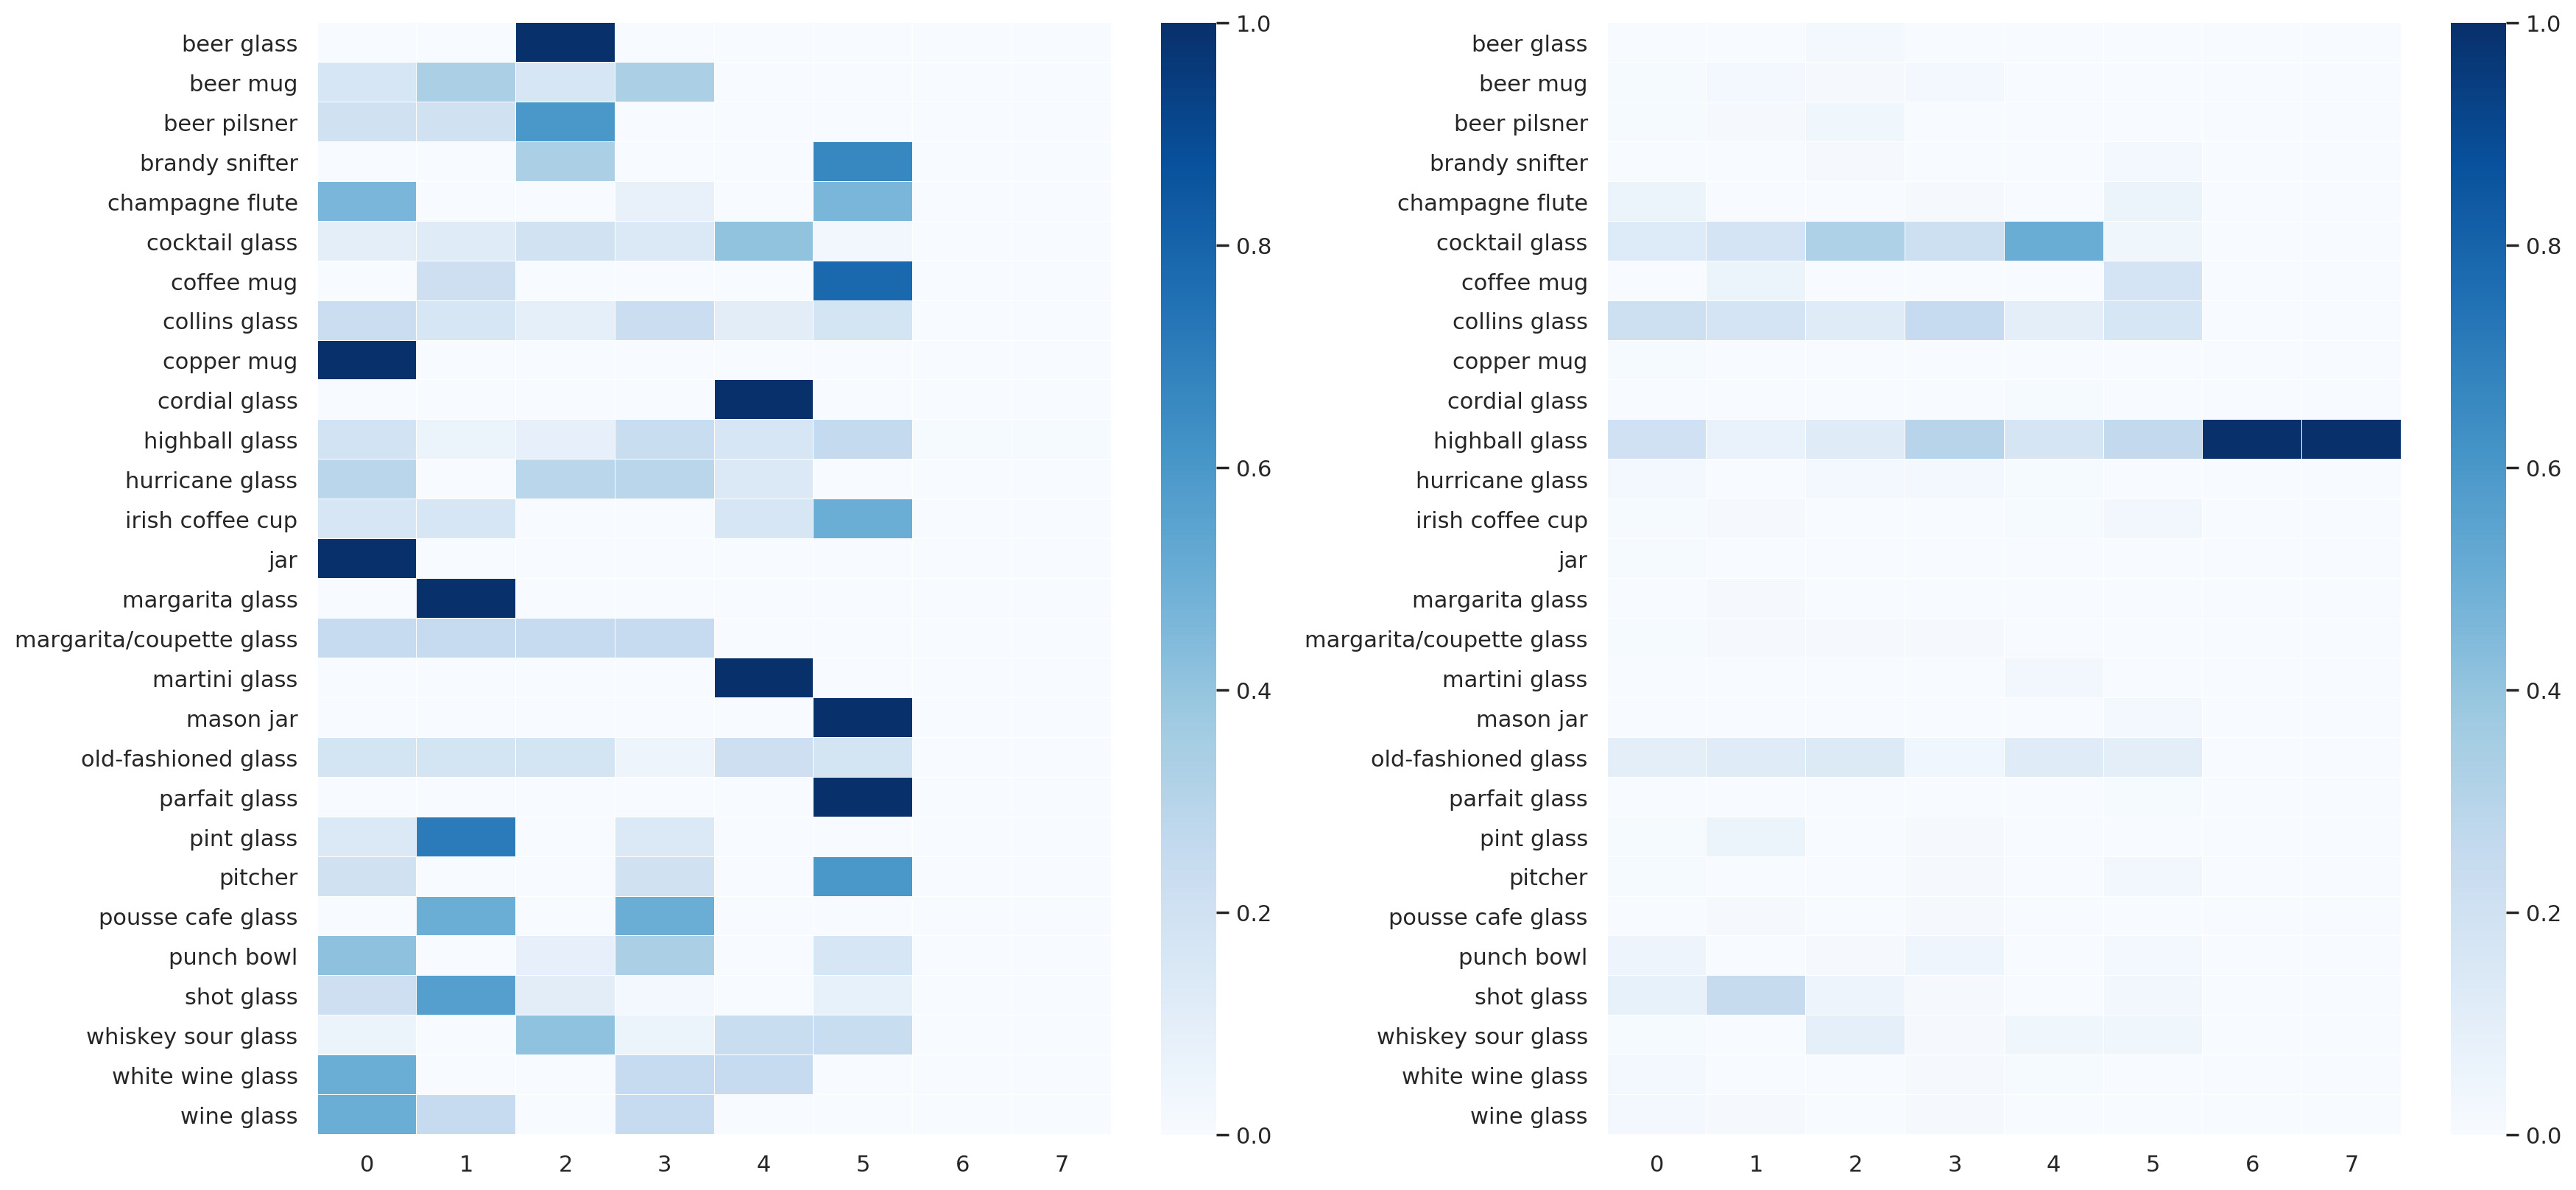

In [23]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(glass_row, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(glass_col, linewidths = .01, cmap="Blues", ax=axs[1])

From the confusion matrix and its visualizations it can be seen that while the communities do not generally correspond to drink categories or glass-types, for some specific categories and glass-types the correlation does indeed exist. 

### Categories

Most prominent associations between communities and categories are the following

- Beer $\rightarrow 1$
- Cocktail $\rightarrow 1$
- Cocoa $\rightarrow 5$
- Coffee / Tea $\rightarrow 5$
- Homemade Liqueur $\rightarrow 5$
- Other/Unknown $\rightarrow 5$
- Punch / Party Drink $\rightarrow 3$
- Shot $\rightarrow 1$
- Soft Drink / Soda $\rightarrow 3$

and

- $0 \rightarrow$ Ordinary Drink
- $2 \rightarrow$ Ordinary Drink
- $4 \rightarrow$ Ordinary Drink
- $6 \rightarrow$ Ordinary Drink
- $7 \rightarrow$ Other/Unknown.

Interestingly, many categories with a smaller number of drinks are associated with community 5. As all drinks of Cocoa-category are placed in this community, the other drinks in this community are probably associated with cocoa-style ingredients.

Here, it is noteworthy, that the community $\rightarrow$ Category associations do not necessarily represent 'meaningful' associations since Ordinary Drink is clearly the largest drink category. Same logic holds also for the two last associations since communities 6 and 7 have only one observations in them.

### Glass-types

The most prominent associations between communities and glass types are the following:

- Beer Glass $\rightarrow 2$
- Copper Mug $\rightarrow 0$
- Cordial Glass $\rightarrow 4$
- Jar $\rightarrow 3$
- Margarita Glass $\rightarrow 3$
- Martini Glass $\rightarrow 3$
- Mason Jar $\rightarrow 3$
- Parfait Glass $\rightarrow 3$

Similarly as with categories, some of these associations are concerned with glass-types or communities that have a support of very few observations and do not necessarily correspond to 'meaningful' correlations.

To properly account for the effect of the size of communities and categories/glass-types, an association rule analysis is conducted on the data.

In [24]:
transactions_cat = []
transactions_glass = []

for i, c in partition.items():
    
    category = categories[i]
    glass_type = glass_types[i]
    transactions_cat += [(c, category)]
    transactions_glass += [(c, glass_type)]
    
transactions_cat = np.array(transactions_cat)
transactions_glass = np.array(transactions_glass)

In [25]:
from mlxtend.frequent_patterns import apriori, association_rules

items_cat = np.unique(transactions_cat)
items_glass = np.unique(transactions_glass)

In [26]:
def encode(df, items):
    encoded_vals = []
    for index, row in df.iterrows():
        labels = {}
        uncommons = list(set(items) - set(row))
        commons = list(set(items).intersection(row))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    return pd.DataFrame(encoded_vals)

In [27]:
df_cat = pd.DataFrame(transactions_cat)
df_glass = pd.DataFrame(transactions_glass)

ohe_cat = encode(df_cat, items_cat)
ohe_glass = encode(df_glass, items_glass)

In [28]:
# min_support=0.002 filters out the 1-observation communities

freq_items_cat = apriori(ohe_cat, min_support=0.002, use_colnames=True, verbose=1)
freq_items_glass = apriori(ohe_glass, min_support=0.002, use_colnames=True, verbose=1)

Processing 546 combinations | Sampling itemset size 3
Processing 1611 combinations | Sampling itemset size 3


In [29]:
rules_cat = association_rules(freq_items_cat, metric="confidence", min_threshold=0.5)
rules_cat

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Beer),(1),0.023810,0.155678,0.012821,0.538462,3.458824,0.009114,1.829365
1,(Shot),(1),0.089744,0.155678,0.047619,0.530612,3.408403,0.033648,1.798774
2,(2),(Ordinary Drink),0.135531,0.503663,0.097070,0.716216,1.422015,0.028808,1.748997
3,(4),(Ordinary Drink),0.184982,0.503663,0.153846,0.831683,1.651269,0.060678,2.948826
4,(Cocoa),(5),0.016484,0.186813,0.016484,1.000000,5.352941,0.013404,inf
5,(Coffee / Tea),(5),0.045788,0.186813,0.032967,0.720000,3.854118,0.024413,2.904239
6,(Homemade Liqueur),(5),0.021978,0.186813,0.014652,0.666667,3.568627,0.010546,2.439560
7,(Other/Unknown),(5),0.062271,0.186813,0.031136,0.500000,2.676471,0.019502,1.626374


In [30]:
rules_glass = association_rules(freq_items_glass, metric="confidence", min_threshold=0.5)
rules_glass

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(white wine glass),(0),0.007326,0.179487,0.003663,0.500000,2.785714,0.002348,1.641026
1,(wine glass),(0),0.007326,0.179487,0.003663,0.500000,2.785714,0.002348,1.641026
2,(pint glass),(1),0.012821,0.155678,0.009158,0.714286,4.588235,0.007162,2.955128
3,(shot glass),(1),0.067766,0.155678,0.038462,0.567568,3.645787,0.027912,1.952495
4,(beer glass),(2),0.003663,0.135531,0.003663,1.000000,7.378378,0.003167,inf
5,(beer pilsner),(2),0.009158,0.135531,0.005495,0.600000,4.427027,0.004253,2.161172
6,(4),(cocktail glass),0.184982,0.228938,0.093407,0.504950,2.205624,0.051057,1.557546
7,(martini glass),(4),0.005495,0.184982,0.005495,1.000000,5.405941,0.004478,inf
8,(brandy snifter),(5),0.005495,0.186813,0.003663,0.666667,3.568627,0.002637,2.439560
9,(coffee mug),(5),0.042125,0.186813,0.032967,0.782609,4.189258,0.025098,3.740659


Association rule mining with 0.5 confidence performed on the partition data (with filtering out itemsets with less than 0.002 support, i.e. one-observation communities) seems to conduct somewhat similar results as the analysis of confusion matrix/heatmaps in terms of the most relevant associations. The correlation to previos analysis is, however, clearly stronger for categories as it is for glass-types. This kind of result is expected as glass-types with really low support were more common than categories with similarly low support.

Here, it is noteworthy that the association rules represented here are directional, while relevance of an association, in this context, isn't necessarily defined only by strength of an one directional mapping but should rather reflect the strength of a bijective mapping.

Next, wordclouds are constructed for each community by utilizing TF-IDF statistic to better understand the underlying characteristics of these communities.

First, the ingredients are parsed to form 'documents' for each community.

In [31]:
punctuation = string.punctuation + '…'

def map_punctuation(s):
    return np.array([char not in punctuation for char in s])

token_arrays = np.empty(n_of_communities+1,object)
token_arrays.fill([])

for i, row in enumerate(data):
    partition_i = list(partition.values())[i]
    #s = row[23] # For instructions
    s = " ".join([i for i in row[8:23] if isinstance(i, str)]) # For ingredients
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[partition_i] = np.append(token_arrays[partition_i], token)
    

Here, the tf-idf values are calculated for each word in each document and used construct the wordclouds.

In [32]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))

In [33]:
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp

In [34]:
wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    s = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(s)
    wordclouds.append(wordcloud)


### Community-ingredients wordcloud visualizations:

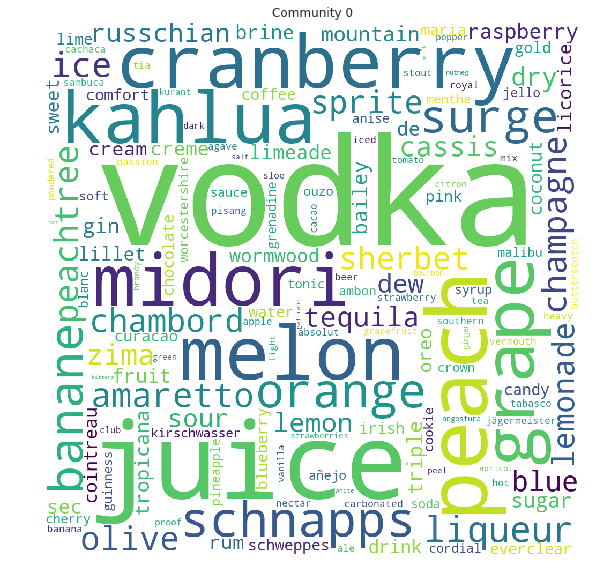

In [35]:
i = 0
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Based on the wordcloud, community 0 seems to contain mostly fresh, vodka-based drinks with fruity/sweet flavors. This is consistent with the previous analysis as the community should consist mostly of ordinary drinks, cocktails, punches and party drinks.

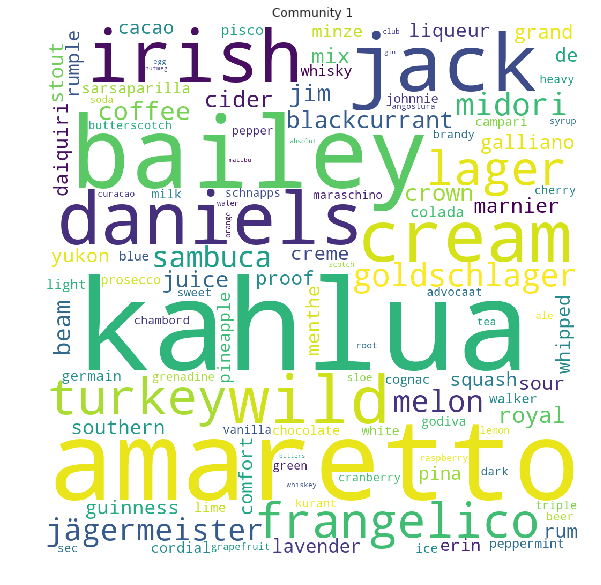

In [36]:
i = 1
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 1 seems to contain variety of different whiskeys and other strong tastes combined with occasional soft, creamy alcohols. Based on previous analysis, this community is expected to have mostly shots and ordinary drinks.

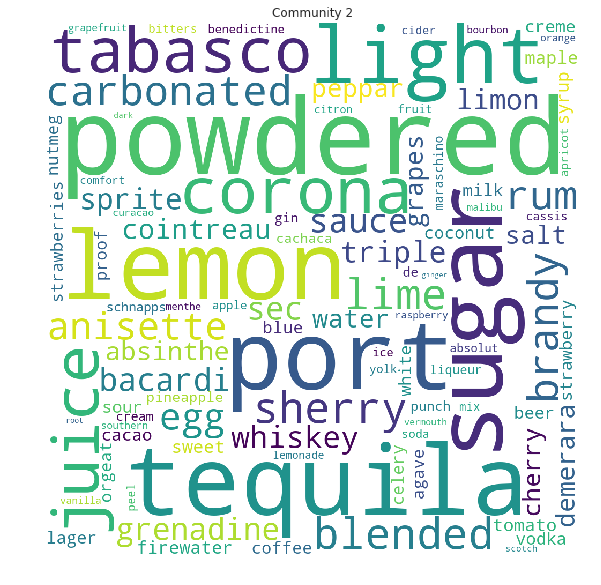

In [37]:
i = 2
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

This community seems to have sour but yet sweet tastes (lemon, lime) in its most ingredients combined with spicy tastes of tabasco and tequila. It is reasonable that these ingredients are grouped in their own community as it is common to see them together.

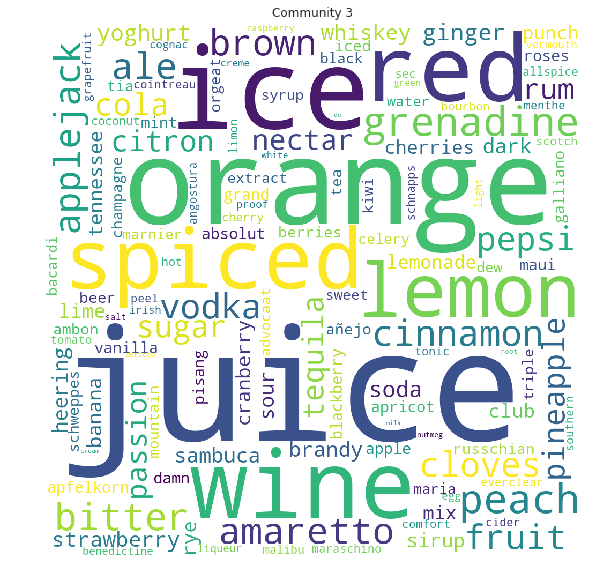

In [38]:
i = 3
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 3 seems to have a wide variety of mostly wine and/or orange(juice) based drinks.

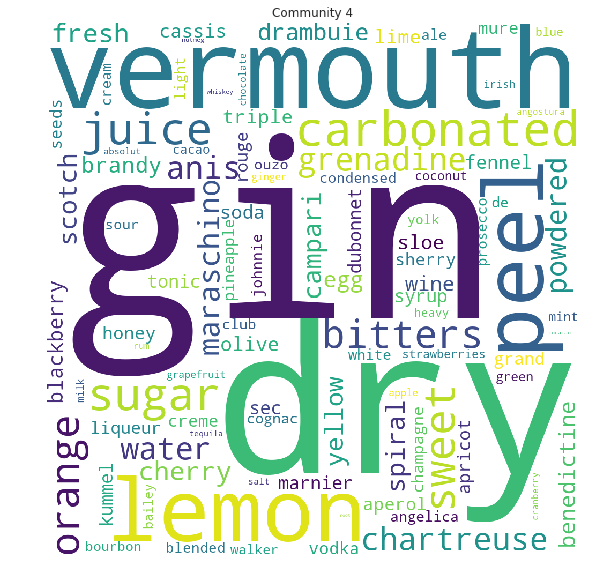

In [39]:
i = 4
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 4 seems to be mostly about dry and bitter drinks with gin and vermouth being the most common alcohols. Yet again it is expected to see these ingredients grouped in their own community.

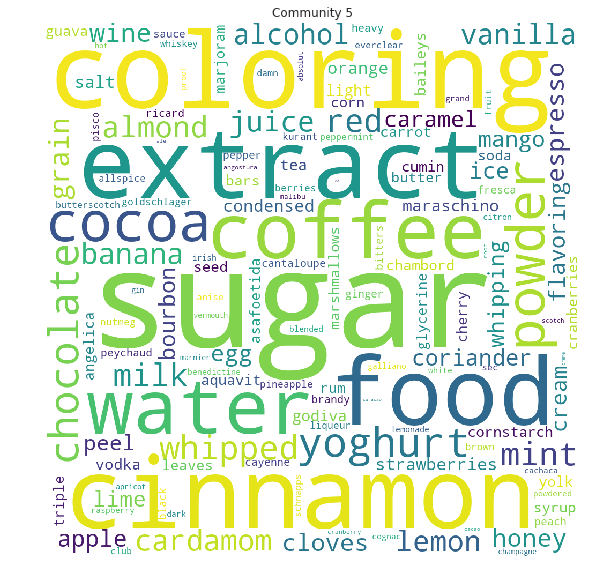

In [40]:
i = 5
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Among the most characteristic ingredients in the community 5 seem to include coffee/cocoa/cinnamon/vanilla which seems to be consistent with the previous analysis as this community should contain ingredients that are often associated with cocoa and coffee drinks.

### Concluding analysis:

As previously stated, the communities found with the Louvain algorithm do not have proper overall correspondance to the drink categories nor the glass types. There exists, however, some useful associations, especially between communities and categories, as shown in previous analysis. The lack of direct correspondance is somewhat expected, as the network used for the community detection is based on ingredients and accounting only the ingredients of a drink may not be enough information to determine its category of glass-type. Ingredients do, however, give us useful heuristics in categorizing the drinks based on different aspects, as seen in the wordclouds above. Indeed, each community (excluding the one-drink communities), seems to consist of its own, distinct and reasonable 'type-defining' sets of ingredients which are often expected to occur together.

# 4) Discussion

This notebook analyzes a dataset containing comprehensive information about different drinks including, for instance, their category, ingredients and instructions. After preliminary analysis on the data, a network of drinks is constructed using edge weights to represent the number of shared ingredients within two drinks. After constructing and providing different visualizations on the network, community detection is conducted on the network with the resulted communities being compared with existing drink categories and glass-types.

The central results of the community analysis were that, while the formed communities didn't have proper correspondance to the drink categories of glass-types, there were still some clear associations between communities and categories. For instance, most cocoa and coffee -based drinks were associated within a same community. Furthermore, after constructing wordclouds of the ingredients of each community, a central finding was that while the correspondance to the pre-existing category labels was rather weak, the communities were still quite succesfully represented by their unique, distinguishable type-defining ingredient sets. For instance, one community consisted of drinks that had tequila, lemon/lime and tabasco among their most frequent ingredients while another community was characterized by dry and bitter tastes combined with gin and vermouth.